In [1]:
# imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import set_config; set_config(display='diagram')

In [2]:
from scipy import stats

# sklearn preproc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import RobustScaler, OneHotEncoder, OrdinalEncoder
from sklearn.metrics import make_scorer

from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import RandomForestRegressor

In [3]:
# You can use this direct download link if you don't want to create a Kaggle account
data = pd.read_csv("/data/houses_train_raw.csv")
data

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


In [4]:
# Create train set
X = data.drop(columns=['SalePrice','Id'])
y = data.SalePrice
X.shape

(1460, 79)

In [71]:
X.dtypes.value_counts()

object     43
int64      33
float64     3
dtype: int64

In [6]:
# Create a categorical DataFrame
feat_categorical_nunique = X.select_dtypes(include='object').nunique()

In [7]:
feat_categorical_nunique.sum()

252

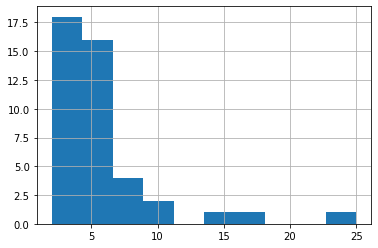

In [8]:
feat_categorical_nunique.hist();

In [9]:
# categorical features to one-hot-encode
feat_categorical_small = list(feat_categorical_nunique[feat_categorical_nunique < 7].index)

In [10]:
len(feat_categorical_small)

34

In [12]:
# Create pipeline for raw data
preproc_numerical_baseline = make_pipeline(
    SimpleImputer(),
    MinMaxScaler())

preproc_categorical_baseline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore"))

preproc_baseline = make_column_transformer(
    (preproc_numerical_baseline, make_column_selector(dtype_include=["int64", "float64"])),
    (preproc_categorical_baseline, feat_categorical_small),
    remainder="drop")

preproc_baseline

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('minmaxscaler',
                                                  MinMaxScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x1682e8100>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore...
                                 ['MSZoning', 'Street', 'Alley', 'LotShape',
                                  'LandContour', 'Utilities', 'LotConfig',
                                  'LandSlope', 'BldgType', 'RoofStyle',
                                  'MasVnrType', 'ExterQual', 'ExterCond',
                                  'Foundation', 'BsmtQual', 'BsmtCond',
                                  'BsmtExposure', 'BsmtFinType1',
                                  'BsmtFinType2', 'Heating', 'HeatingQC',
                                  'CentralAir', 'Electrical', 'KitchenQual',
                                  'FireplaceQu', 'GarageType', 'GarageFinish',
                                  'GarageQual', 'GarageCond', 'PavedDrive', ...])])

In [13]:
shape_preproc_baseline = preproc_baseline.fit_transform(X).shape
shape_preproc_baseline

(1460, 183)

In [15]:
# Decision Tree for preprocessing for estimation
pipe_baseline = make_pipeline(preproc_baseline, DecisionTreeRegressor())
pipe_baseline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1682e8100>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder'...
                                                   'LotConfig', 'LandSlope',
                                                   'BldgType', 'RoofStyle',
                                                   'MasVnrType', 'ExterQual',
                                                   'ExterCond', 'Foundation',
                                                   'BsmtQual', 'BsmtCond',
                                                   'BsmtExposure',
                                                   'BsmtFinType1',
                                                   'BsmtFinType2', 'Heating',
                                                   'HeatingQC', 'CentralAir',
                                                   'Electrical', 'KitchenQual',
                                                   'FireplaceQu', 'GarageType',
                                                   'GarageFinish', 'GarageQual',
                                                   'GarageCond', 'PavedDrive', ...])])),
                ('decisiontreeregressor', DecisionTreeRegressor())])

In [17]:
# Cross Validation
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import make_scorer

# This is our metric to minimize
rmsle = make_scorer(lambda y_true, y_pred: mean_squared_log_error(y_true, y_pred)**0.5)

# This is our score to maximize
rmsle_neg = make_scorer(lambda y_true, y_pred: -1 * mean_squared_log_error(y_true, y_pred)**0.5)

# Equivalent formulation
rmsle_neg = make_scorer(
    lambda y_true, y_pred: mean_squared_log_error(y_true, y_pred)**0.5,
    greater_is_better=False
)

In [18]:
# Final Score
score_baseline = cross_val_score(pipe_baseline, X, y, cv=5, scoring=rmsle).mean()
score_baseline

0.20659816920503885

In [19]:
X_test = pd.read_csv("https://wagon-public-datasets.s3.amazonaws.com/houses_test_raw.csv")
X_test_ids = X_test['Id'] # Keep ids
X_test = X_test.drop(columns=['Id'])

# Predict y_pred_baseline
pipe_baseline.fit(X,y)
y_pred_baseline = pipe_baseline.predict(X_test)
y_pred_baseline

array([129000., 155000., 173000., ..., 142500.,  93500., 192000.])

In [20]:
# Store as seperate CSV for future use
results = pd.concat([X_test_ids, pd.Series(y_pred_baseline, name="SalePrice")], axis=1)
results.head(1)

,Id,SalePrice
0,1461,129000.0


In [21]:
results.to_csv("data/baseline.csv", header=True, index=False)

In [23]:
# Define specific order for features

feature_A_sorted_values = ['bad', 'average', 'good'] 
feature_B_sorted_values = ['dirty', 'clean', 'new']

encoder = OrdinalEncoder(
    categories=[
        feature_A_sorted_values,
        feature_B_sorted_values
    ],
    handle_unknown="use_encoded_value",
    unknown_value=-1
)

# Just some random training data
XX = [
    ['good', 'dirty'],
    ['bad', 'new'],
    ['average', 'clean'],
]

encoder.fit(XX)

encoder.transform([
        ['bad', "dirty"],
        ["average", "clean"],
        ['good', 'new'],
        ['bad', 'oooops never seen this label before']
])

array([[ 0.,  0.],
       [ 1.,  1.],
       [ 2.,  2.],
       [ 0., -1.]])

In [24]:
# Splitting categorical preprocessor

feat_ordinal_dict = {
    # considers "missing" as "neutral"
    "BsmtCond": ['missing', 'Po', 'Fa', 'TA', 'Gd'],
    "BsmtExposure": ['missing', 'No', 'Mn', 'Av', 'Gd'],
    "BsmtFinType1": ['missing', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
    "BsmtFinType2": ['missing', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
    "BsmtQual": ['missing', 'Fa', 'TA', 'Gd', 'Ex'],
    "Electrical": ['missing', 'Mix', 'FuseP', 'FuseF', 'FuseA', 'SBrkr'],
    "ExterCond": ['missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    "ExterQual": ['missing', 'Fa', 'TA', 'Gd', 'Ex'],
    "Fence": ['missing', 'MnWw', 'GdWo', 'MnPrv', 'GdPrv'],
    "FireplaceQu": ['missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    "Functional": ['missing', 'Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ'],
    "GarageCond": ['missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    "GarageFinish": ['missing', 'Unf', 'RFn', 'Fin'],
    "GarageQual": ['missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    "HeatingQC": ['missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    "KitchenQual": ['missing', 'Fa', 'TA', 'Gd', 'Ex'],
    "LandContour": ['missing', 'Low', 'Bnk', 'HLS', 'Lvl'],
    "LandSlope": ['missing', 'Sev', 'Mod', 'Gtl'],
    "LotShape": ['missing', 'IR3', 'IR2', 'IR1', 'Reg'],
    "PavedDrive": ['missing', 'N', 'P', 'Y'],
    "PoolQC": ['missing', 'Fa', 'Gd', 'Ex'],
}

feat_ordinal = sorted(feat_ordinal_dict.keys()) # sort alphabetically
feat_ordinal_values_sorted = [feat_ordinal_dict[i] for i in feat_ordinal]

encoder_ordinal = OrdinalEncoder(
    categories=feat_ordinal_values_sorted,
    dtype= np.int64,
    handle_unknown="use_encoded_value",
    unknown_value=-1 # Considers unknown values as worse than "missing"
)

preproc_ordinal = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="missing"),
    encoder_ordinal,
    MinMaxScaler()
)

preproc_ordinal

Pipeline(steps=[('simpleimputer',
                 SimpleImputer(fill_value='missing', strategy='constant')),
                ('ordinalencoder',
                 OrdinalEncoder(categories=[['missing', 'Po', 'Fa', 'TA', 'Gd'],
                                            ['missing', 'No', 'Mn', 'Av', 'Gd'],
                                            ['missing', 'Unf', 'LwQ', 'Rec',
                                             'BLQ', 'ALQ', 'GLQ'],
                                            ['missing', 'Unf', 'LwQ', 'Rec',
                                             'BLQ', 'ALQ', 'GLQ'],
                                            ['missing', 'Fa', 'TA', 'Gd', 'Ex'],
                                            ['missing', 'Mix', 'FuseP...
                                            ['missing', 'Po', 'Fa', 'TA', 'Gd',
                                             'Ex'],
                                            ['missing', 'Po', 'Fa', 'TA', 'Gd',
                                             'Ex'],
                                            ['missing', 'Fa', 'TA', 'Gd', 'Ex'],
                                            ['missing', 'Low', 'Bnk', 'HLS',
                                             'Lvl'],
                                            ['missing', 'Sev', 'Mod', 'Gtl'],
                                            ['missing', 'IR3', 'IR2', 'IR1',
                                             'Reg'],
                                            ['missing', 'N', 'P', 'Y'],
                                            ['missing', 'Fa', 'Gd', 'Ex']],
                                dtype=<class 'numpy.int64'>,
                                handle_unknown='use_encoded_value',
                                unknown_value=-1)),
                ('minmaxscaler', MinMaxScaler())])

In [25]:
# Define numerical feature once-for-all
feat_numerical = sorted(X.select_dtypes(include=["int64", "float64"]).columns)

preproc_numerical = make_pipeline(
    KNNImputer(),
    MinMaxScaler()
)

In [26]:
# Define nominal features to one-hot-encode as the remaining ones (non numerical, non ordinal)
feat_nominal = sorted(list(set(X.columns) - set(feat_numerical) - set(feat_ordinal)))

preproc_nominal = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore")
)

In [27]:
preproc = make_column_transformer(
    (preproc_numerical, feat_numerical),
    (preproc_ordinal, feat_ordinal),
    (preproc_nominal, feat_nominal),
    remainder="drop")

preproc


ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('knnimputer', KNNImputer()),
                                                 ('minmaxscaler',
                                                  MinMaxScaler())]),
                                 ['1stFlrSF', '2ndFlrSF', '3SsnPorch',
                                  'BedroomAbvGr', 'BsmtFinSF1', 'BsmtFinSF2',
                                  'BsmtFullBath', 'BsmtHalfBath', 'BsmtUnfSF',
                                  'EnclosedPorch', 'Fireplaces', 'FullBath',
                                  'GarageArea', 'GarageCars', 'GarageYrBlt',
                                  'GrLivArea', 'HalfBath', 'Kitc...
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['Alley', 'BldgType', 'CentralAir',
                                  'Condition1', 'Condition2', 'Exterior1st',
                                  'Exterior2nd', 'Foundation', 'GarageType',
                                  'Heating', 'HouseStyle', 'LotConfig',
                                  'MSZoning', 'MasVnrType', 'MiscFeature',
                                  'Neighborhood', 'RoofMatl', 'RoofStyle',
                                  'SaleCondition', 'SaleType', 'Street',
                                  'Utilities'])])

In [28]:
pd.DataFrame(preproc.fit_transform(X,y)).head()

,0,1,2,3,4,5,6,7,8,9,...,206,207,208,209,210,211,212,213,214,215
0,0.119780,0.413559,0.0,0.375,0.125089,0.0,0.333333,0.0,0.064212,0.000000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
1,0.212942,0.000000,0.0,0.375,0.173281,0.0,0.000000,0.5,0.121575,0.000000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
2,0.134465,0.419370,0.0,0.375,0.086109,0.0,0.333333,0.0,0.185788,0.000000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
3,0.143873,0.366102,0.0,0.375,0.038271,0.0,0.333333,0.0,0.231164,0.492754,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
4,0.186095,0.509927,0.0,0.500,0.116052,0.0,0.333333,0.0,0.209760,0.000000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0


In [29]:
# Statistical Feature selection

from sklearn.feature_selection import SelectPercentile, mutual_info_regression

preproc_transformer = make_column_transformer(
    (preproc_numerical, make_column_selector(dtype_include=["int64", "float64"])),
    (preproc_ordinal, feat_ordinal),
    (preproc_nominal, feat_nominal),
    remainder="drop")

preproc_selector = SelectPercentile(
    mutual_info_regression,
    percentile=25, # keep only 25% of all features
)

preproc = make_pipeline(
    preproc_transformer,
    preproc_selector
)
preproc

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('knnimputer',
                                                                   KNNImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x16836f520>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('ordi...
                                                   'CentralAir', 'Condition1',
                                                   'Condition2', 'Exterior1st',
                                                   'Exterior2nd', 'Foundation',
                                                   'GarageType', 'Heating',
                                                   'HouseStyle', 'LotConfig',
                                                   'MSZoning', 'MasVnrType',
                                                   'MiscFeature',
                                                   'Neighborhood', 'RoofMatl',
                                                   'RoofStyle', 'SaleCondition',
                                                   'SaleType', 'Street',
                                                   'Utilities'])])),
                ('selectpercentile',
                 SelectPercentile(percentile=25,
                                  score_func=<function mutual_info_regression at 0x16838a160>))])

In [30]:
preproc.fit_transform(X,y).shape

(1460, 54)

In [88]:
# To remove features that do not help predict our target

test_pipe = Pipeline([
    ('process', preproc),
    ('lasso', Lasso())
])

In [89]:
test_pipe.fit(X,y)

Pipeline(steps=[('process',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(transformers=[('pipeline-1',
                                                                   Pipeline(steps=[('knnimputer',
                                                                                    KNNImputer()),
                                                                                   ('minmaxscaler',
                                                                                    MinMaxScaler())]),
                                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x16850ac40>),
                                                                  ('pipeline-2',
                                                                   Pipeline(steps=[('simpleimputer',
                                                                                    SimpleImputer(fill_value='missing',
                                                                                                  s...
                                                                    'Exterior1st',
                                                                    'Exterior2nd',
                                                                    'Foundation',
                                                                    'GarageType',
                                                                    'Heating',
                                                                    'HouseStyle',
                                                                    'LotConfig',
                                                                    'MSZoning',
                                                                    'MasVnrType',
                                                                    'MiscFeature',
                                                                    'Neighborhood',
                                                                    'RoofMatl',
                                                                    'RoofStyle',
                                                                    'SaleCondition',
                                                                    'SaleType',
                                                                    'Street',
                                                                    'Utilities'])])),
                                 ('selectpercentile',
                                  SelectPercentile(percentile=50,
                                                   score_func=<function mutual_info_regression at 0x16838a160>))])),
                ('lasso', Lasso())])

In [90]:
coefs = pd.DataFrame(data=abs(test_pipe['lasso'].coef_), columns=['coef']).sort_values(by='coef')
coefs

,coef
73,0.000000e+00
56,0.000000e+00
59,0.000000e+00
8,0.000000e+00
50,7.321546e-13
...,...
12,7.272849e+04
3,8.145245e+04
2,8.434692e+04
100,9.193844e+04


In [96]:
selected = coefs.iloc[54:].index
selected

Int64Index([ 65,  92,  80,  74,  25,  31,  43,  57,  34,  40,  52,   9,  75,
             64,  29,  35,  82, 104, 107,  81,  19,  21,  85,  98,  88, 105,
             69,  14,   1,  87, 106,  16,  28,  42,  10,  30,  76,  18,  33,
             38,   7,   0,  94,   4,  23,  20,  93,  99,  13,  12,   3,   2,
            100,  11],
           dtype='int64')

In [102]:
from sklearn.preprocessing import FunctionTransformer

transfm = FunctionTransformer(lambda x: x[:,selected])

preproc_final = Pipeline([
    ('init_preproc', preproc),
    ('select_cols', transfm)
])

In [104]:
preproc_final.fit_transform(X, y)

array([[0.        , 0.        , 0.        , ..., 0.0334198 , 0.        ,
        0.1400982 ],
       [1.        , 0.        , 0.        , ..., 0.03879502, 0.        ,
        0.20654664],
       [0.        , 0.        , 0.        , ..., 0.04650728, 0.        ,
        0.15057283],
       ...,
       [0.        , 0.        , 0.        , ..., 0.03618687, 0.        ,
        0.18854337],
       [1.        , 0.        , 0.        , ..., 0.03934189, 0.        ,
        0.17643208],
       [0.        , 0.        , 0.        , ..., 0.04037019, 0.        ,
        0.20556465]])

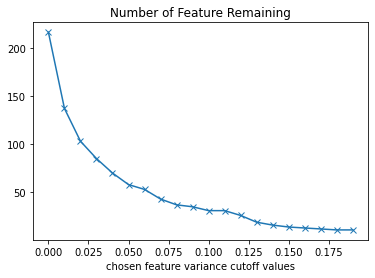

In [32]:
# Removing features with the lowest variance
from sklearn.feature_selection import VarianceThreshold

def number_feature_remaining(cutoff=0):
    preproc_transformer = make_column_transformer(
        (preproc_numerical, feat_numerical),
        (preproc_ordinal, feat_ordinal),
        (preproc_nominal, feat_nominal),
        remainder="drop")

    preproc_selector = VarianceThreshold(cutoff)

    preproc = make_pipeline(
        preproc_transformer,
        preproc_selector)

    return preproc.fit_transform(X).shape[1]

cutoff_values = np.arange(0, 0.2, 0.01)
plt.plot(cutoff_values, [number_feature_remaining(t) for t in cutoff_values], marker='x')
plt.xlabel("chosen feature variance cutoff values")
plt.title("Number of Feature Remaining");

In [33]:
# ☝️ We could decide to put a 0.025 threshold on the categorical features to divide their number by more than half

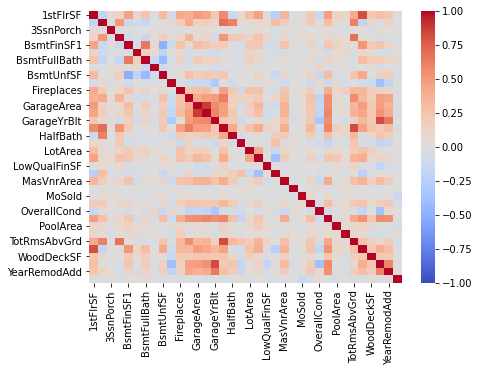

In [34]:
# Pearson's correlation to visualise if numerical features are corelated and to what degree
corr_num = X[feat_numerical].corr()
plt.figure(figsize=(7,5))
sns.heatmap(corr_num, cmap='coolwarm',vmin=-1, vmax=1);

In [35]:
# Check which columns to drop based on too high correlation 
num_corr_threshold = 0.95

corr_num = X[feat_numerical].corr()
corr_num_upper_triangle = corr_num.where(np.triu(np.ones(corr_num.shape),k=1).astype(np.bool)).abs()
num_col_to_drop = [column for column in corr_num_upper_triangle.columns if any(corr_num_upper_triangle[column] > num_corr_threshold)]
num_col_to_drop

[]

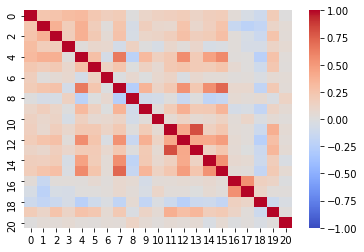

In [36]:
# Spearman's rank correlation to check ordinally encoded features
X_ordinally_encoded = pd.DataFrame(preproc_ordinal.fit_transform(X[feat_ordinal]))
sns.heatmap(X_ordinally_encoded.corr(method='spearman'), cmap='coolwarm', vmin=-1, vmax=1);

In [37]:
# Now to filter pipeline 
from sklearn.base import BaseEstimator, TransformerMixin


class CustomFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, num_corr_threshold=0.95):
        self.num_corr_threshold = num_corr_threshold

    def fit(self, X, y=None):
        corr_num = X[feat_numerical].corr()
        upper = corr_num.where(np.triu(np.ones(corr_num.shape), k=1).astype(np.bool)).abs()
        self.num_col_to_drop = [column for column in upper.columns if any(upper[column] > self.num_corr_threshold)]
        self.num_col = X[feat_numerical].columns
        return self

    def transform(self, X, y=None):
        df = pd.DataFrame(X, columns=self.num_col)
        return df.drop(columns=self.num_col_to_drop)
    
# Test it here
CustomFeatureSelector(num_corr_threshold=0.2).fit_transform(X[feat_numerical]).head(2)

,1stFlrSF,3SsnPorch,BsmtFinSF2,BsmtHalfBath,EnclosedPorch,KitchenAbvGr,LowQualFinSF,MiscVal,MoSold,ScreenPorch,YrSold
0,856,0,0,0,0,1,0,0,2,0,2008
1,1262,0,0,1,0,1,0,0,5,0,2007


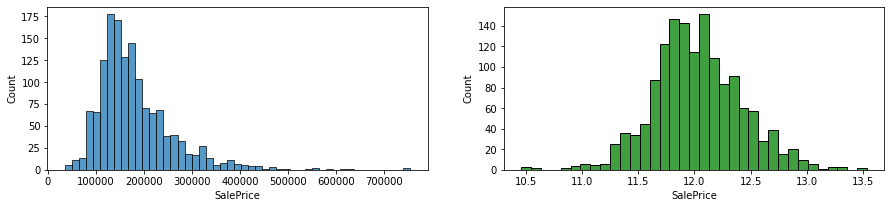

In [39]:
# Target engineering

y_log = np.log(y)
plt.figure(figsize=(15,3))
plt.subplot(1,2,1)
sns.histplot(y)
plt.subplot(1,2,2)
sns.histplot(y_log, color='green');

In [40]:
# Create your new scorer to minimize
from sklearn.metrics import mean_squared_error
rmse = make_scorer(lambda y_true, y_pred: mean_squared_error(y_true, y_pred)**0.5)

# Create your new scorer to maximize
rmse_neg = make_scorer(lambda y_true, y_pred: -1 * mean_squared_error(y_true, y_pred)**0.5)

In [41]:
# Final version of the pre-processing pipeline engine

encoder_ordinal = OrdinalEncoder(
    categories=feat_ordinal_values_sorted,
    dtype= np.int64,
    handle_unknown="use_encoded_value",
    unknown_value=-1 # Considers unknown values as worse than "missing"
)

preproc_ordinal = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="missing"),
    encoder_ordinal,
    MinMaxScaler()
)

preproc_numerical = make_pipeline(
    KNNImputer(),
    MinMaxScaler()
)

preproc_transformer = make_column_transformer(
    (preproc_numerical, make_column_selector(dtype_include=["int64", "float64"])),
    (preproc_ordinal, feat_ordinal),
    (preproc_nominal, feat_nominal),
    remainder="drop")

preproc_selector = SelectPercentile(
    mutual_info_regression,
    percentile=50, # keep only xx% of all features )
)
preproc = make_pipeline(
    preproc_transformer,
    preproc_selector
)
preproc

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('knnimputer',
                                                                   KNNImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x16850ac40>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('ordi...
                                                   'CentralAir', 'Condition1',
                                                   'Condition2', 'Exterior1st',
                                                   'Exterior2nd', 'Foundation',
                                                   'GarageType', 'Heating',
                                                   'HouseStyle', 'LotConfig',
                                                   'MSZoning', 'MasVnrType',
                                                   'MiscFeature',
                                                   'Neighborhood', 'RoofMatl',
                                                   'RoofStyle', 'SaleCondition',
                                                   'SaleType', 'Street',
                                                   'Utilities'])])),
                ('selectpercentile',
                 SelectPercentile(percentile=50,
                                  score_func=<function mutual_info_regression at 0x16838a160>))])

In [42]:
# Check shape
preproc_fitted = preproc.fit(X,y)
preproc_fitted_log = preproc.fit(X,y_log)
preproc_fitted_log.transform(X).shape

(1460, 108)

In [43]:
# SOLUTION
allow_grid_searching = False

# Cache the preprocessing step of the pipeline
from tempfile import mkdtemp
from shutil import rmtree
cachedir = mkdtemp()

In [44]:
# Ridge with normal target
model = Ridge()
pipe_ridge = make_pipeline(preproc, model, memory=cachedir)
cross_val_score(pipe_ridge, X, y, cv=5, scoring=rmsle).mean()

0.16868247674612724

In [45]:
# Rige with log-target (much better)
model = Ridge()
pipe_ridge = make_pipeline(preproc, model, memory=cachedir)
cross_val_score(pipe_ridge, X, y_log, cv=5, scoring=rmse).mean()

0.13997127635662363

In [46]:
# GridSearch the Ridge regularization
if allow_grid_searching:
    param_grid =  {'ridge__alpha': np.linspace(0.5,2,num=20)}
    search_ridge = GridSearchCV(pipe_ridge, param_grid=param_grid, 
                              cv=5, n_jobs=-1, verbose=2, scoring=rmse_neg)

    search_ridge.fit(X, y_log);
    print(search_ridge.best_params_)
    search_ridge.best_score_

In [47]:
# Implementing KNN
model = KNeighborsRegressor()
pipe_knn = make_pipeline(preproc, model)

In [48]:
scores = cross_val_score(pipe_knn, X, y_log, cv=5, scoring=rmse)
scores.mean()

0.19647581485768148

In [49]:
# GridSearch the KNN
if allow_grid_searching:
    param_grid =  {'kneighborsregressor__n_neighbors': [3,4,5,6,7,8,9,10,15,20,30]}
    search_knn = GridSearchCV(pipe_knn, param_grid=param_grid, 
                              cv=3, n_jobs=-1, verbose=2, scoring=rmse_neg)

    search_knn.fit(X, y_log);
    print(search_knn.best_params_)
    search_knn.best_score_

In [50]:
# Implementing SVM
model = SVR(kernel='linear')
pipe_svm = make_pipeline(preproc, model, memory=cachedir)
cross_val_score(pipe_svm, X, y_log, cv=5, scoring=rmse).mean()

0.13770212397939005

In [51]:
model = SVR(kernel='rbf', C = 10)
pipe_svm_rbf = make_pipeline(preproc, model, memory=cachedir)
cross_val_score(pipe_svm_rbf, X, y_log, cv=5, scoring=rmse).mean()

0.13593423894752993

In [52]:
# GridSearch
if allow_grid_searching:
    param_grid =  {'svr__C': [0.5, 0.7, 1, 2, 5, 10],
                  'svr__epsilon': [0.01, 0.05, 0.1, 0.2, 0.5],
                   #'svr__coef0': [0.0, 0.1, 0.5,1],
                  }
    search_svm_rbf = GridSearchCV(pipe_svm_rbf, param_grid=param_grid, 
                              cv=5, n_jobs=-1, verbose=2, scoring=rmse_neg)

    search_svm_rbf.fit(X, y_log);
    svm_rbf_best = search_svm_rbf.best_estimator_
    print(search_svm_rbf.best_params_)
    search_svm_rbf.best_score_

In [53]:
# Implementing Trees
from sklearn.tree import DecisionTreeRegressor

model = DecisionTreeRegressor(max_depth=50, min_samples_leaf=20)
pipe = make_pipeline(preproc, model, memory=cachedir)
score = cross_val_score(pipe, X, y_log, cv=5, scoring=rmse)
print(score.std())
score.mean()

0.01010089853652749


0.18886309153311512

In [54]:
# Random Forest

model = RandomForestRegressor(max_depth=50,min_samples_leaf=20)
pipe = make_pipeline(preproc, model, memory=cachedir)
score = cross_val_score(pipe, X, y_log, cv=5, scoring=rmse)
print(score.std())
score.mean()

0.00736650950428782


0.1623153868014719

In [55]:
# Boosted Trees
model = AdaBoostRegressor(
    base_estimator=DecisionTreeRegressor(max_depth=None))

pipe = make_pipeline(preproc, model, memory=cachedir)
score = cross_val_score(pipe, X, y_log, cv=5, scoring=rmse)
print(score.std())
score.mean()

0.008087105088485468


0.13954211874292446

In [56]:
model = GradientBoostingRegressor(n_estimators=100, verbose=0)
pipe_gb = make_pipeline(preproc, model, memory=cachedir)
score = cross_val_score(pipe_gb, X, y_log, cv=5, scoring=rmse)
print(score.std())
score.mean()

0.00968882477015238


0.12669553801339656

In [57]:
if allow_grid_searching:
    grid = {
         'gradientboostingregressor__n_estimators': stats.randint(50,300),
    #     'gradientboostingregressor__learning_rate':stats.uniform(0.05,0.3),
    #     'gradientboostingregressor__loss': ['ls', 'lad', 'huber', 'quantile'],
    #    'gradientboostingregressor__max_depth': stats.randint(3,5),    
    #    'gradientboostingregressor__min_samples_split':stats.randint(2,10),
    #    'gradientboostingregressor__subsample':[0.95, 1], # 1 default
         'gradientboostingregressor__max_features':stats.randint(0.7,1), # default None, i.e = n_features
    }

    search_gb = RandomizedSearchCV(pipe_gb, grid, scoring=rmse_neg, n_iter=8, cv=5, n_jobs=1, verbose=2,)

    # Fit data to Grid Search
    search_gb.fit(X, y_log);
    print(search_gb.best_params_)
    search_gb.best_score_
    
    # Plot results of gridsearch
    df_cv_results_ = pd.DataFrame(search_gb.cv_results_)
    sns.scatterplot(x="param_gradientboostingregressor__n_estimators", y='mean_test_score', data=df_cv_results_)
    sns.scatterplot(x="param_gradientboostingregressor__max_features", y='mean_test_score', data=df_cv_results_)

In [58]:
# Stacking
gboost = GradientBoostingRegressor(n_estimators=100)
ridge = Ridge()
svm = SVR(C=1, epsilon=0.05)
adaboost = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=None))


model = VotingRegressor(
    estimators = [("gboost", gboost),("adaboost", adaboost),("ridge", ridge), ("svm_rbf", svm)],
    weights = [1,1,1,1], # to equally weight the two models
    n_jobs=-1
)

pipe_ensemble = make_pipeline(preproc, model, memory=cachedir)

score = cross_val_score(pipe_ensemble, X, y_log, cv=5, scoring=rmse, n_jobs=-1)
print(score.std())
score.mean()

0.010712666288149503


0.12135804500963052

In [59]:
gboost = GradientBoostingRegressor(n_estimators=100)
ridge = Ridge()
svm = SVR(C=1, epsilon=0.05)
adaboost = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=None))

model = StackingRegressor(
    estimators=[("gboost", gboost),("adaboost", adaboost),("ridge", ridge), ("svm_rbf", svm)],
    
    final_estimator=LinearRegression(),
    cv=5,
    n_jobs=-1
)

pipe_stacking = make_pipeline(preproc, model, memory=cachedir)
score = cross_val_score(pipe_stacking, X, y_log, cv=5, scoring=rmse, n_jobs=-1)
print(score.std())
score.mean()

0.01043935716228318


0.12054267419839174

In [60]:
from xgboost import XGBRegressor

In [61]:
# Create eval test just for early stopping purpose (XGBOOST and Deep Learning)
X_train, X_eval, y_train_log, y_eval_log = train_test_split(X,y_log,random_state=42)

In [62]:
# Instanciate model
model_xgb = XGBRegressor(max_depth=10, n_estimators=300, learning_rate=0.1)

In [63]:
# Integrate XGB into Sklearn's pipeline

pipe_xgb = make_pipeline(preproc, model_xgb)
cross_val_score(pipe_xgb,X,y_log,cv=5,scoring=rmse,n_jobs=-1).mean()

0.13458939538651793